# Feature Engineering

In [ ]:
import pandas as pd

df = pd.read_csv('btc_features_output.csv')
df.head()

# Show the first 5 rows
print(df.head())

# Show the column names
print(df.columns.tolist())

     start_time  cg_longShortRatio  cg_longAccount    cg_buy  cq_is_shutdown  \
0  1.681603e+12           1.370370       -0.772040 -0.375654             0.0   
1  1.681607e+12          -0.666667       -0.756042  0.521808             0.0   
2  1.681610e+12           0.851852       -0.764389 -0.416774             0.0   
3  1.681614e+12          -0.259259       -0.764389 -0.536372             0.0   
4  1.681618e+12           0.666667       -0.772735 -0.319397             0.0   

   cq_netflow_total  cq_transactions_count_inflow  \
0          0.258809                     -0.205667   
1         -0.134542                     -0.403108   
2          0.186270                     -0.154479   
3         -0.339551                     -0.496344   
4          0.519098                     -0.092322   

   cq_transactions_count_outflow  cq_reserve  cq_reserve_usd  ...  \
0                       0.863636    0.586101       -0.008144  ...   
1                      -0.363636    0.581715       -0.016572  

# Feature Selection

Measures Mutual Informatino (MI) as a selection method.
However,
- MI doesn't always capture the temporal dependencies between the features that are critical for time series problems. Eg, momentum, volatility
- Features that don't have clear temporal or state-transition relevance might be selected purely based on MI scores, even if they don't fit well with the model's inherent dynamics.
-  a better approach could be to first identify features that capture market states

                                              Feature  Mutual_Information
0                        gn_distribution_balance_wbtc            0.620353
1               gn_addresses_supply_balance_more_100k            0.611712
2                                      cq_reserve_usd            0.582644
3             gn_distribution_balance_grayscale_trust            0.581257
4                              gn_supply_active_3y_5y            0.572032
5          gn_derivatives_futures_annualized_basis_3m            0.519619
6                    gn_supply_active_more_2y_percent            0.498175
7                    gn_supply_active_more_1y_percent            0.490392
8            gn_indicators_hodler_net_position_change            0.440129
9              gn_market_realized_volatility_3_months            0.409678
10             gn_market_realized_volatility_6_months            0.392446
11                                         cq_reserve            0.382313
12                      gn_blockchain_

<ipython-input-8-e64c7c0ff125>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, x='Mutual_Information', y='Feature', palette='viridis')


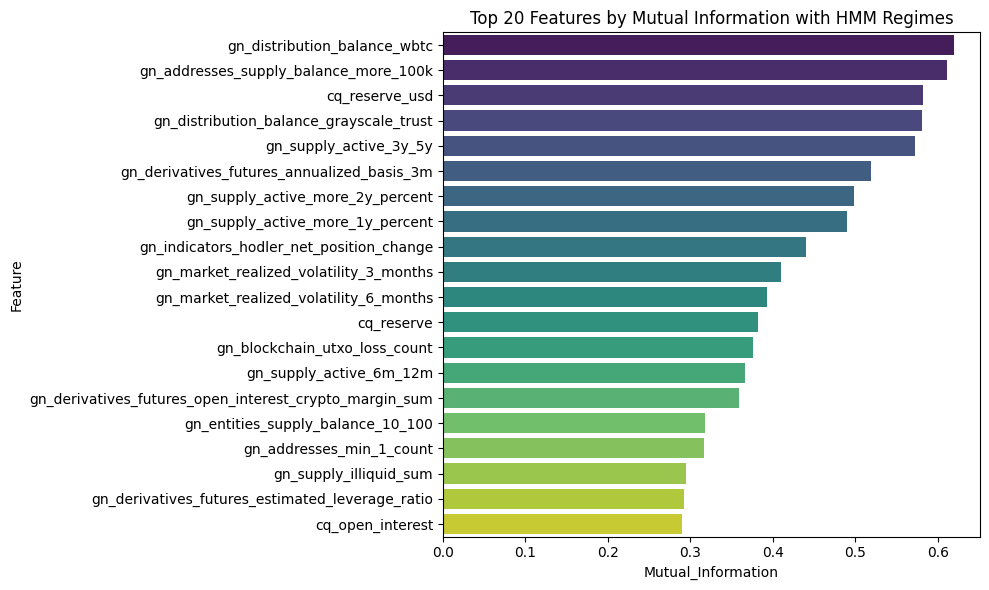

In [ ]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load and Prepare Data ===
# Load your data
df = pd.read_csv('btc_features_output.csv')

# Drop datetime cols early and keep a clean copy for HMM + MI
X = df.drop(columns=['start_time', 'date','cq_taker_buy_ratio'])

# Clean inf/nan
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# Fit HMM
n_states = 3
model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", random_state=42)
model.fit(X)

# Predict hidden states
predicted_states = model.predict(X)

# Compute MI — use X only (safe, clean)
mi_scores = mutual_info_classif(X, predicted_states, discrete_features=False, random_state=42)

# Create MI DataFrame
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Information': mi_scores
}).sort_values(by='Mutual_Information', ascending=False).reset_index(drop=True)

# Show top 20
print(mi_df.head(20))

# Visualize
top20 = mi_df.head(20)
plt.figure(figsize=(10,6))
sns.barplot(data=top20, x='Mutual_Information', y='Feature', palette='viridis')
plt.title("Top 20 Features by Mutual Information with HMM Regimes")
plt.tight_layout()
plt.show()

# Save MI results
mi_df.to_csv('feature_importance_hmm_mi.csv', index=False)


# Correlation Matrix Analysis

If two features have a very high correlation (say, Pearson’s r > 0.9), it means they carry very similar information.
Keeping both:

- Adds redundancy
- Can cause multicollinearity problems (in models like linear regression, but less of an issue for HMM)
- Can unnecessarily increase model complexity and overfitting risk


<ipython-input-14-2ef59acc49c9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_pairs['OrderedPair'] = corr_pairs.apply(lambda row: tuple(sorted([row['Feature1'], row['Feature2']])), axis=1)


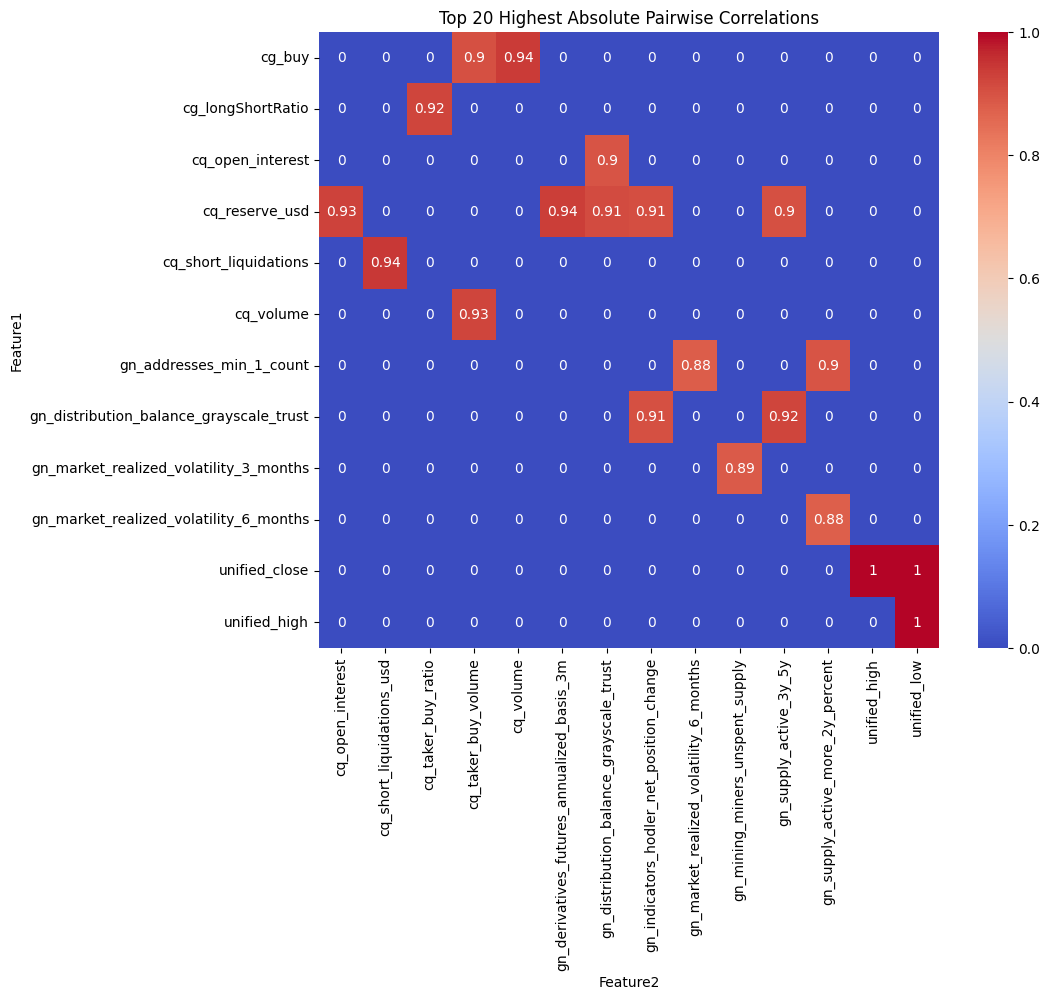

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('btc_features_output.csv')

# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix for numeric columns only
corr_matrix = numeric_df.corr()

# Unstack the correlation matrix to get pairwise correlations and reset index
corr_pairs = corr_matrix.abs().unstack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Remove self-correlations (i.e., where Feature1 == Feature2) and duplicate pairs (A-B and B-A)
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]
corr_pairs['OrderedPair'] = corr_pairs.apply(lambda row: tuple(sorted([row['Feature1'], row['Feature2']])), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset='OrderedPair').drop(columns='OrderedPair')

# Get top 20 highest absolute correlations
top_20_pairs = corr_pairs.sort_values(by='Correlation', ascending=False).head(20)

# Create a pivot table for the top 20 correlations
top_20_matrix = top_20_pairs.pivot(index='Feature1', columns='Feature2', values='Correlation').fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top_20_matrix, annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1)
plt.title("Top 20 Highest Absolute Pairwise Correlations")
plt.show()


# Feature importance using XGBoast
XGBoost is a tree-based model, making it more suitable for capturing complex, non-linear relationships in the data, which is common in financial and crypto datasets. It provides clear and interpretable feature importance metrics, helping to identify key variables for your alpha strategy.


Assumption 1: Focus on the features that directly related to price movements in the future(1 day forward).


      unified_close    return  target  future_target
8319       0.132510  0.229812       1            0.0
8320       0.152883  0.153743       0            0.0
8321       0.153686  0.005254       0            0.0
8322       0.132059 -0.140725       0            1.0
8323       0.160022  0.211751       1            0.0
8324       0.165356  0.033333       0            0.0
8325       0.181298  0.096411       0            0.0
8326       0.197377  0.088684       0           -1.0
8327       0.103933 -0.473429      -1           -1.0
8328       0.072664 -0.300859      -1            1.0
8329       0.208396  1.867957       1            0.0
8330       0.206025 -0.011381       0            0.0
8331       0.209316  0.015975       0            0.0
8332       0.249962  0.194188       0            0.0
8333       0.235536 -0.057713       0            0.0
8334       0.226938 -0.036504       0            1.0
8335       0.309267  0.362782       1            0.0
8336       0.323324  0.045450       0         

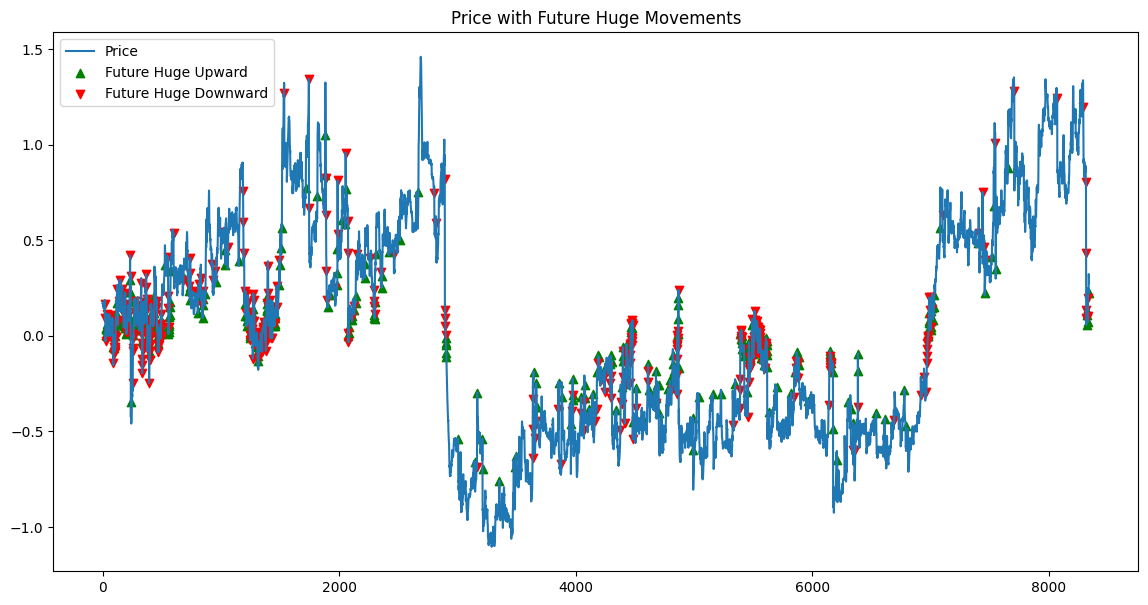

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your processed DataFrame and 'target' is the column you want to predict
X = df.drop(columns=['date'])  # Features, excluding 'date' for now

# Calculate percentage change for price movements
df['return'] = df['unified_close'].pct_change()
threshold = 0.20  # Define the threshold for huge price movements

# Create target variable for significant price movement
df['target'] = 0  # Default: no significant movement
df.loc[df['return'] >= threshold, 'target'] = 1  # Huge upward movement
df.loc[df['return'] <= -threshold, 'target'] = -1  # Huge downward movement

# Shift the target variable to predict future price movements
df['future_target'] = df['target'].shift(-1)

# Drop rows with NaN values due to shifting
df = df.dropna(subset=['future_target'])

# Inspect the target variable
print(df[['unified_close', 'return', 'target', 'future_target']].tail(20))  # Display last 20 rows

# Plot the price and highlight future huge movements (up and down)
plt.figure(figsize=(14,7))
plt.plot(df['unified_close'], label='Price')

# Plot future target movements
plt.scatter(df.index[df['future_target'] == 1], df['unified_close'][df['future_target'] == 1], color='green', label='Future Huge Upward', marker='^', alpha=1)
plt.scatter(df.index[df['future_target'] == -1], df['unified_close'][df['future_target'] == -1], color='red', label='Future Huge Downward', marker='v', alpha=1)

plt.legend()
plt.title('Price with Future Huge Movements')
plt.show()


Run the feature importance using XGBoast

Accuracy: 0.90


<Figure size 1200x800 with 0 Axes>

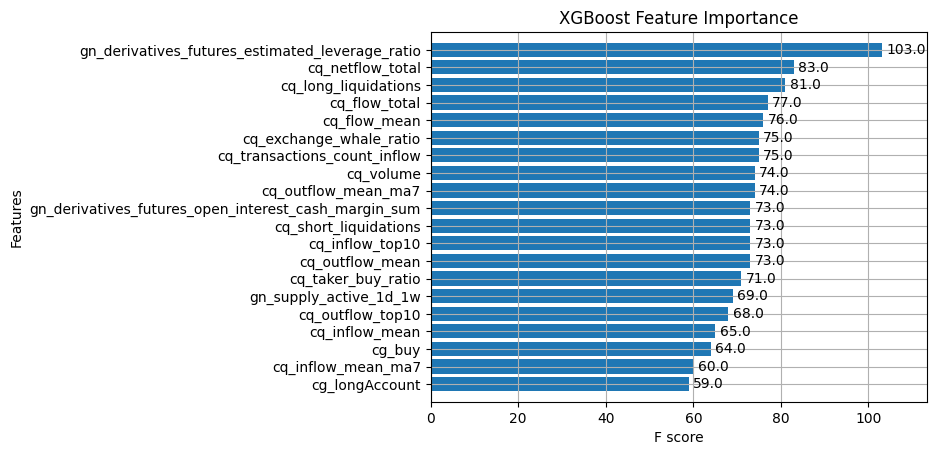

Index(['start_time', 'cg_longShortRatio', 'cg_longAccount', 'cg_buy',
       'cq_is_shutdown', 'cq_netflow_total', 'cq_transactions_count_inflow',
       'cq_transactions_count_outflow', 'cq_reserve', 'cq_reserve_usd',
       'cq_funding_rates', 'cq_flow_mean', 'cq_flow_total',
       'cq_exchange_whale_ratio', 'cq_outflow_mean', 'cq_outflow_mean_ma7',
       'cq_outflow_top10', 'cq_inflow_mean', 'cq_inflow_mean_ma7',
       'cq_inflow_top10'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming df is your processed DataFrame and 'target' is the column you want to predict
X = df.drop(columns=['date', 'future_target', 'start_time', 'unified_close', 'return'])  # Features, excluding 'date' and 'future_target'
y = df['future_target'].apply(lambda x: 1 if x != 0 else 0)  # Set 1 for any significant movement, 0 for no movement

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=20, height=0.8)
plt.title('XGBoost Feature Importance')
plt.show()

print(df.columns[:20])


Since it brings a good result, try ammending the target instead of daily price difference to expected return over a future period of window.

      unified_close  future_avg_return  target
8319       0.132510          -0.003408       0
8320       0.152883           0.046699       0
8321       0.153686           0.075935       0
8322       0.132059           0.372863       0
8323       0.160022           0.233433       0
8324       0.165356          -0.371461       0
8325       0.181298          -0.599204      -1
8326       0.197377           0.055831       0
8327       0.103933           0.982287       1
8328       0.072664           1.880612       1
8329       0.208396           0.199457       0
8330       0.206025           0.143244       0
8331       0.209316           0.084191       0
8332       0.249962           0.237255       0
8333       0.235536           0.372712       0
8334       0.226938           0.356228       0
8335       0.309267          -0.106294       0
8336       0.323324           0.002663       0
8337       0.307780          -0.555180      -1
8338       0.276394          -0.841080      -1


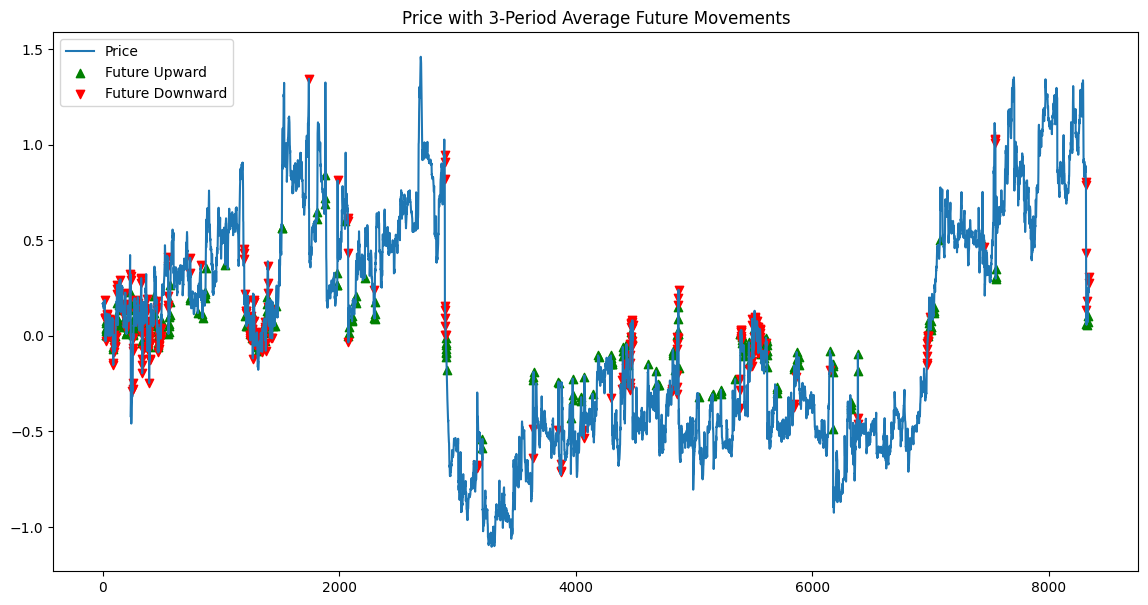

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('btc_features_output.csv')

# Assuming df is your processed DataFrame and 'unified_close' is the price
window = 3  # number of periods to look ahead
threshold = 0.5 # e.g., 5% avg return as threshold for significant movement

# Calculate average % price change over the next 7 days
df['future_avg_return'] = (df['unified_close'].shift(-window) - df['unified_close']) / df['unified_close']

# Create target variable based on future average return
df['target'] = 0  # Default: no significant movement
df.loc[df['future_avg_return'] >= threshold, 'target'] = 1  # Significant upward
df.loc[df['future_avg_return'] <= -threshold, 'target'] = -1  # Significant downward

# Drop rows with NaN values caused by shifting
df = df.dropna(subset=['future_avg_return'])

# Inspect the result
print(df[['unified_close', 'future_avg_return', 'target']].tail(20))

# Plot the price and mark significant movements
plt.figure(figsize=(14, 7))
plt.plot(df['unified_close'], label='Price')

# Plot points with significant future average return
plt.scatter(df.index[df['target'] == 1], df['unified_close'][df['target'] == 1],
            color='green', label='Future Upward', marker='^', alpha=1)
plt.scatter(df.index[df['target'] == -1], df['unified_close'][df['target'] == -1],
            color='red', label='Future Downward', marker='v', alpha=1)

plt.legend()
plt.title(f'Price with {window}-Period Average Future Movements')
plt.show()


Accuracy: 1.00


<Figure size 1200x800 with 0 Axes>

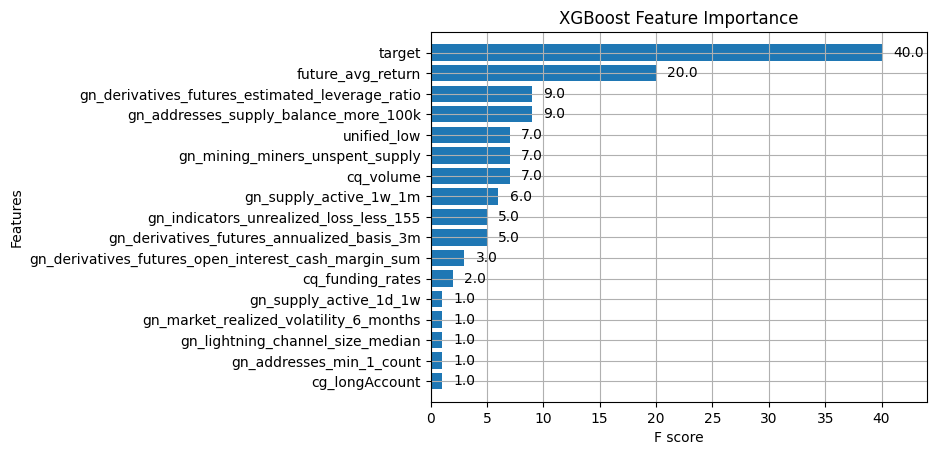

Index(['start_time', 'cg_longShortRatio', 'cg_longAccount', 'cg_buy',
       'cq_is_shutdown', 'cq_netflow_total', 'cq_transactions_count_inflow',
       'cq_transactions_count_outflow', 'cq_reserve', 'cq_reserve_usd',
       'cq_funding_rates', 'cq_flow_mean', 'cq_flow_total',
       'cq_exchange_whale_ratio', 'cq_outflow_mean', 'cq_outflow_mean_ma7',
       'cq_outflow_top10', 'cq_inflow_mean', 'cq_inflow_mean_ma7',
       'cq_inflow_top10'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming df is your processed DataFrame and 'target' is the column you want to predict
X = df.drop(columns=['date', 'start_time', 'unified_close'])  # Features, excluding 'date' and 'future_target'
y = df['target'].apply(lambda x: 1 if x != 0 else 0)  # Set 1 for any significant movement, 0 for no movement

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=20, height=0.8)
plt.title('XGBoost Feature Importance')
plt.show()

print(df.columns[:20])


Assumption 2: Focus on the features that directly related to whale ration which assume that large holders (whales) moving their coins to exchanges is a leading indicator of market behavior.


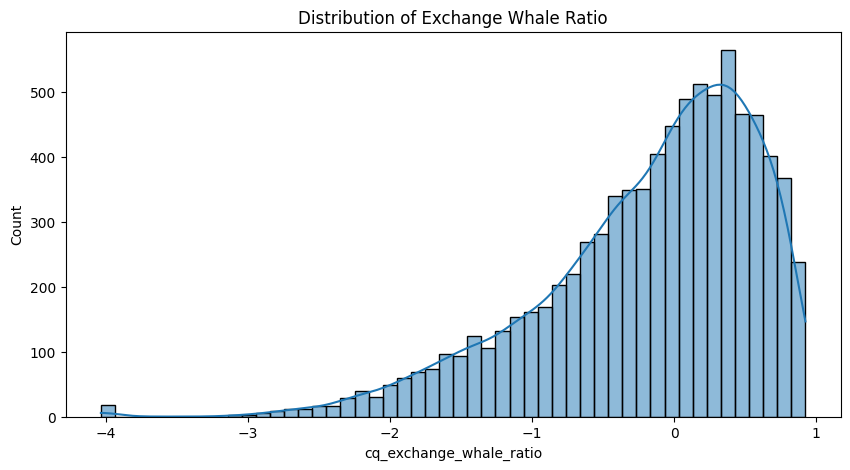

future_target
-1.0   -0.366155
 0.0   -0.154409
 1.0   -0.371010
Name: cq_exchange_whale_ratio, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df already loaded and processed
# Plot distribution
plt.figure(figsize=(10,5))
sns.histplot(df['cq_exchange_whale_ratio'], bins=50, kde=True)
plt.title('Distribution of Exchange Whale Ratio')
plt.show()

# Mean whale ratio before huge upward / downward moves
print(df.groupby('future_target')['cq_exchange_whale_ratio'].mean())


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:22:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Top 20 Most Important Features:
                                       feature  importance
0                                   start_time    0.372616
49                      gn_supply_active_3y_5y    0.053738
16                              cq_inflow_mean    0.051826
9                               cq_reserve_usd    0.045522
6                 cq_transactions_count_inflow    0.035270
32  gn_derivatives_futures_annualized_basis_3m    0.030353
43      gn_market_realized_volatility_6_months    0.024661
26                    gn_addresses_min_1_count    0.014901
51            gn_supply_active_more_1y_percent    0.012065
55      gn_supply_sth_lth_realized_value_ratio    0.011856
58                                 unified_low    0.011422
14                         cq_outflow_mean_ma7    0.010725
35     gn_distribution_balance_grayscale_trust    0.010714
50                     gn_supply_active_6m_12m    0.010582
7                cq_transactions_count_outflow    0.009947
40    gn_indicators_hodl

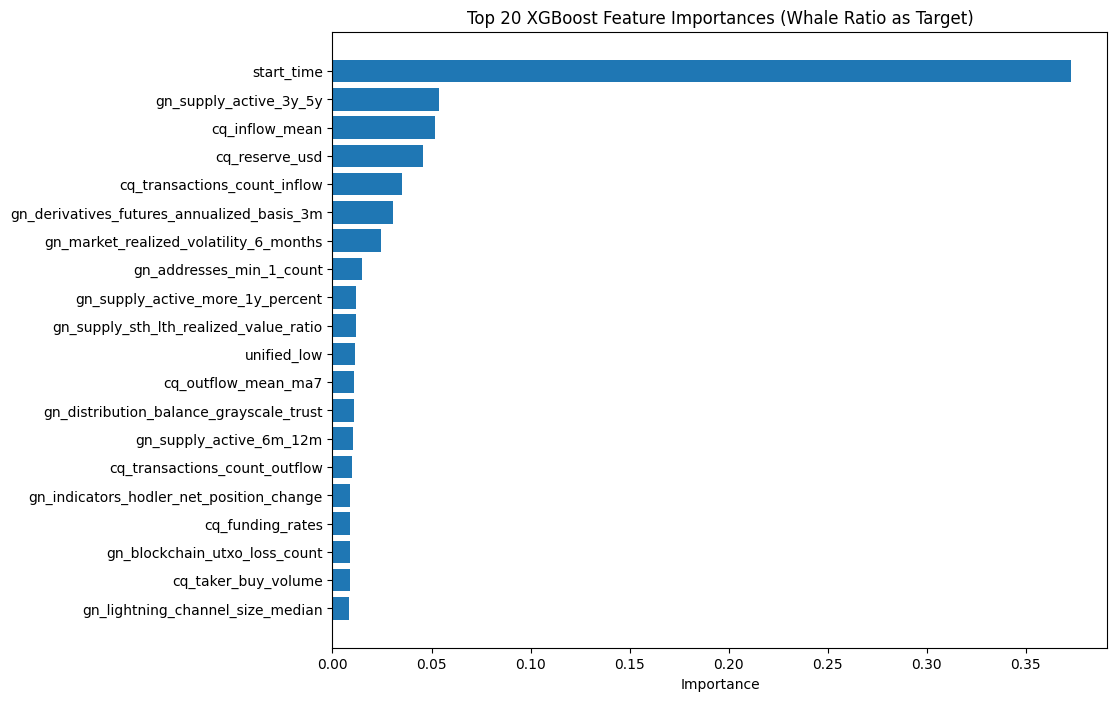

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('btc_features_output.csv')

# Create target: classify if whale ratio > 0.5
df['target'] = (df['cq_exchange_whale_ratio'] > 0.5).astype(int)

# Features
X = df.drop(columns=['date', 'cq_exchange_whale_ratio', 'target'])
y = df['target']

# Clean missing values
X = X.dropna()
y = y.loc[X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Get feature importance
importances = model.feature_importances_
feature_names = X.columns

# Create DataFrame for sorting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance descending
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Print top 20 features
print("Top 20 Most Important Features:")
print(importance_df.head(20))

# Optional: plot
plt.figure(figsize=(10,8))
plt.barh(importance_df['feature'].head(20)[::-1], importance_df['importance'].head(20)[::-1])
plt.xlabel("Importance")
plt.title("Top 20 XGBoost Feature Importances (Whale Ratio as Target)")
plt.show()